In [ ]:
using Pkg;
Pkg.add(["LightGraphs", "GraphPlot", "Laplacians","Colors"]);
using LinearAlgebra;
using LightGraphs, GraphPlot, Laplacians,Colors;

## Graphs and Networks

Take for example, a sample directed graph:

![](directedGraph.png)

In [19]:
# creating the above directed graph
let 
    edges = [(1, 2), (1, 3), (2,4), (3, 2), (3, 5), (4, 5), (4, 6), (5, 2), (5, 6)]
    global graph = DiGraph(Edge.(edges))
end

{6, 9} directed simple Int64 graph

## Incidence matrix
- shows the relationship between nodes (columns) via edges (rows)
- edges are connected by exactly two nodes (duh), with direction indicated by the sign of each row in the edge column
    + a value of $1$ at $A_{12}$ indicates that edge 1 is directed towards node $1$, or node $2$ is the destination node for edge $1$
- edge rows sum to 0 and constant column vectors $c(1,\dots,1)$ are in the nullspace
- cannot represent self-loops (nodes connected to themselves)

_Using Strang's definition in the LALFD book, a graph consists of nodes defined as columns $n$ and edges $m$ as rows between the nodes. An **Incidence Matrix** A is $m\,\times\,n$. For the above sample directed graph, we can generate its incidence matrix._

In [20]:
# create an incidence matrix from a directed graph
function create_incidence(graph::DiGraph)
    M = zeros(Int, ne(graph), nv(graph))
    
    # each edge maps to a row in the incidence matrix
    for (i, e) in edges(graph) |> enumerate
        M[i, e.src] = -1
        M[i, e.dst] = 1
    end
    return M
end

A = create_incidence(graph)

9×6 Array{Int64,2}:
 -1   1   0   0   0  0
 -1   0   1   0   0  0
  0  -1   0   1   0  0
  0   1  -1   0   0  0
  0   0  -1   0   1  0
  0   0   0  -1   1  0
  0   0   0  -1   0  1
  0   1   0   0  -1  0
  0   0   0   0  -1  1

## Creating a graph from an incidence matrix
- reversal of above, shows the relationship between an graph and an incidence matrix

In [21]:
function create_graph(incidence::Array{Int,2})
    n = size(incidence)[2]
    graph = DiGraph(n)

    # find nodes where edge goes out and edge goes in
    v_out = findall(x->x == -1, incidence) # edge goes out of vertex
    v_in = findall(x->x == 1, incidence) # edge goes in of vertex
    
    # match the Cartesian index between the two lists, add edge
    for i in v_in
        for o in v_out
            if o[1] == i[1]
                add_edge!(graph, o[2], i[2])
            end
        end
    end
    return graph
end

create_graph (generic function with 1 method)

## Visualising an incidence matrix
- this is really just visualising a graph, but is this ok?

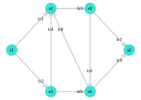

In [22]:
gplot(
    create_graph(A), 
    # manually setting node locations to match the above
    [1.0, 2, 2, 3, 3, 4],
    [0.0, -1, 1, -1, 1, 0],
    nodelabel = ["x$i" for i in 1:nv(graph)],
    edgelabel = ["b$i" for i in 1:ne(graph)],
)

## Laplacian matrix / Kirchhoff matrix
- $A^\top A$, where $A$ is an incidence matrix
- diagonal entries make up the degree matrix
- off-diagonal entries are $-B$, the adjacency matrix

_The **Laplacian Matrix** $L\,=\,A^TA$ is a square matrix, symmetric and positive semidefinite:_

In [23]:
L = A'A

6×6 Array{Int64,2}:
  2  -1  -1   0   0   0
 -1   4  -1  -1  -1   0
 -1  -1   3   0  -1   0
  0  -1   0   3  -1  -1
  0  -1  -1  -1   4  -1
  0   0   0  -1  -1   2

## Degree matrix
- counts the edges into nodes $1,\dots,n$. $D_{ii}$ is the edges for node $i$
- each degree is in the range $1, n-1$; meaning each node is connected to at least one other node and at most all other nodes
- the trace of the diagonal matrix is twice the number of edges. $\frac{tr(D)}{2} = m$ where $m$ = rows of $A$

The Degree matrix counts the edges into nodes, which can be extracted using Julia's Diagonal() constructor:

In [24]:
D = Diagonal(L)

6×6 Diagonal{Int64,Array{Int64,1}}:
 2  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  4  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  3  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  3  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  4  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  2

## Adjacency matrix
- describes connectedness between nodes
- _looks to symmetric and positive definite?_ - is this always the case?

In [25]:
B = -(L - D)

6×6 Array{Int64,2}:
 0  1  1  0  0  0
 1  0  1  1  1  0
 1  1  0  0  1  0
 0  1  0  0  1  1
 0  1  1  1  0  1
 0  0  0  1  1  0

## Kirchhoff's Current Law
- independent solutions to $A^\top y = 0$ = $n - m + 1$, meaning edges - nodes + 1 independent loops to a graph
- balance of currents: flows into a node equals flows out of a node, maintaining equilibrium
- a loop is a cycle of edges that start and ends on the same node

In [26]:
# for incidence matrix A, there are n - m + 1 = 4 solutions
# b1, -b2, -b4
y₁ = [1, -1, 0, -1, 0, 0, 0, 0, 0]
# -b4, b5, b8
y₂ = [0, 0, 0, -1, 1, 0, 0, 1, 0]
# b3,b6,b8
y₃ = [0, 0, 1, 0, 0, 1, 0, 1, 0]
# b6, -b7, b9
y₄ = [0, 0, 0, 0, 0, 1, -1, 0, 1]

[A'y for y in [y₁, y₂, y₃, y₄]]

4-element Array{Array{Int64,1},1}:
 [0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0]

In [27]:
function gplot_nestedloops(nestedloops)
    gplot(
        create_graph(A), 
        # manually setting node locations to match the above
        [1.0, 2, 2, 3, 3, 4],
        [0.0, -1, 1, -1, 1, 0],
        nodelabel = ["x$i" for i in 1:nv(graph)],
        edgelabel = ["b$i" for i in 1:ne(graph)],
        edgelabeldistx=-0.7,
        edgestrokec = [i in nestedloops ? colorant"green" : colorant"lightgrey" for i in 1:ne(graph)]
    )
end

gplot_nestedloops (generic function with 1 method)

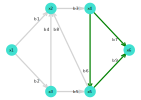

In [28]:
# a really nonfunctional way of implementing the inner nested loop. 
loops = [[1,2,4],[4,5,8],[3,6,8],[6,7,9]];

# step through these loops in the presentation. gplot breaks once you put it in a for loop.
for loop in loops
    IJulia.clear_output()
    gplot_nestedloops(loop) |> display
    sleep(1)
end

## Graph Laplacian Matrix
- $K = A^\top CA$ is a weighted graph Laplacian in which the weights are in $C$
- In standard Laplacian matrix $C = I$

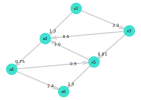

In [29]:
#vector for weights
W = [1.0,2.0,0.75,0.5,0.85,0.9,2.4,3,1.0]

#label edges with weights
gplot(
    graph,
    nodelabel=["x$i" for i in 1:nv(graph)],
    edgelabel=W
)

In [30]:
#diagonal matrix of weights
C = diagm(W)

#weighted Laplacians
K = A'*C*A

6×6 Array{Float64,2}:
  3.0  -1.0   -2.0    0.0    0.0    0.0
 -1.0   5.25  -0.5   -0.75  -3.0    0.0
 -2.0  -0.5    3.35   0.0   -0.85   0.0
  0.0  -0.75   0.0    4.05  -0.9   -2.4
  0.0  -3.0   -0.85  -0.9    5.75  -1.0
  0.0   0.0    0.0   -2.4   -1.0    3.4

## Road-network
An example of using graph theory to solve a difficult problem: navigating a road network.

In a simple example, weights may represent the distance of each edge (i.e. the distance between two nodes); in a sophisticated scenario, weights may be a combination of inputs to determine the expected duration to traverse an edge (such as distance, speed limit, turning cost, vehicle dimensions and weight, expected congestion cost, etc.)

Below is an example of such a graph, calculating expected travel times from 4 nodes to all nodes within an area of Townsville, taking the shortest time from any node as the resultant value of an edge and scaling on a quantize colour scale with 4 breaks.

In [31]:
# road network visual
display("text/html","<iframe src='./isochrone.html' style='border: 0; width: 100%; height: 480px'></iframe>")

# Max-Flow / Min-Cut Theorem

The Max-Flow Min-Cut Theorem represents a network flow optimisation problem where the maximal value of a flow from a Source node $S$ to a Sink node $T$ (i.e. Destination) is equal to the total value of a minimal cut, where edges are only counted if they disconnect the path from a source to a sink.

**Applications**:
- Distribution of Incoming Web Traffic to Server Applications using [Load Balancing techniques](http://david-kempe.com/publications/load-balancing-final.pdf)
- Unifying data flows from cloud-based servers using event-driven architectures.
- Distance of destinations and flow rate of traffic between destinations
- Representing the electrical flow in a distribution grid

**Terminology and base assumptions**
1. For a Max-Flow Min-Cut Theorem, we have Graphs $G$, Vertices $v$ and Edges $e$ denoted as: $G(v,e)$
1. We are only using Directed Graphs to represent the flow of a graph
1. Distinguished vertices as Source $S$ and Sink $T$.
1. For any vertices other than $S$ or $T$, everything that flows in has to come out of the vertex.

**Obeying the Conservation Laws with these Constraints**
1. We can't accumulate more than the incoming flow in the vertices (what goes in must come out)
1. Obey the Conservation Laws: anything that's not found in the Source ($S$) or Sink ($T$) has to leave the node.
1. Can have flows that are cyclical, but can't have self-looping vertices
1. Can increase the flow between vertices by removing specific edges

## Definitions

A flow $f$ is a function defined by the edges on a graph where each edge $f(u,v) \in E$ has a non-negative Capacity $C(u,v)$ is $\mathbb{Z}^+$ and is not greater than the Capacity $C(u,v)$ for that edge.

This can be represented in the following form:

$$
0 \leq\,f(u,v)\,\leq\,C(u,v)\quad\:\forall\:\text{ edges in }G(u,v)
$$

For all vertices other than Source node $S$ and Sink node $T$, everything that flows in has to flow out of the vertex, for example:

$$
\sum_{a\,\in\,N_{in}(v)} f(a,v) = \sum_{b\,\in\,N_{out}(v)} f(v,b)
$$

where: 
- $N_{in}$: set of nodes leading into $v$, and 
- $N_{out}$: set of nodes leading from $v$.

## Calculating Values of a Flow
In the 'Max-Flow Min-Cut Theorem', calculating the value of the flow is defined as the total amount of flow from the source $S$ (= total amount of flow to the sink $T$).

$$
\begin{vmatrix}{f}\end{vmatrix}= \sum_{v\,\in\,N_{out}(S)} f(S,v) - \sum_{v\,\in\,N_{in}(S)} f(v,S)
$$

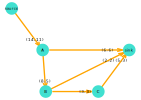

In [32]:
G = SimpleDiGraph(5, 6; seed=18)
edge_capacity = [8, 6, 3, 2, 14, 5]
edge_flow = [5, 6, 3, 2, 11, 3]
node_label = ["A", "B", "source", "C", "sink"]

flow_order = [
    [(8,0), (6,0), (3,0), (2,0), (14,11), (5,0)],
    [(8,5), (6,6), (3,0), (2,0), (14,11), (5,0)],
    [(8,5), (6,6), (3,3), (2,2), (14,11), (5,0)],
    [(8,5), (6,6), (3,3), (2,2), (14,11), (5,3)]
]

colours = [
    [colorant"lightgray",colorant"lightgray",colorant"lightgray",colorant"lightgray",colorant"orange",colorant"lightgray"],
    [colorant"orange",colorant"orange",colorant"lightgray",colorant"lightgray",colorant"orange",colorant"lightgray"],
    [colorant"orange",colorant"orange",colorant"orange",colorant"orange",colorant"orange",colorant"lightgray"],
    [colorant"orange",colorant"orange",colorant"orange",colorant"orange",colorant"orange",colorant"orange"],
]

for i in 1:4
    IJulia.clear_output()
    gplot(
        G,
        [6.0,6.5,1.0,15.0,20.0],
        [2.0,3.0,1.0,3.0,2.0], 
        nodelabel=node_label, 
        edgelabel=flow_order[i],
        edgestrokec=colours[i]
    ) |> display
    sleep(2)
end

## Graph Cut
A graph cut is a partition of the vertices into two disjoint subsets: a set containing the source and a set containing the sink.

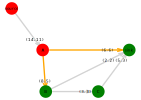

In [33]:
G = SimpleDiGraph(5, 6; seed=18)
node_label = ["A", "B", "source", "C", "sink"]

flow_order = [(8,5), (6,6), (3,3), (2,2), (14,11), (5,3)]

edge_colours = [colorant"orange",colorant"orange",colorant"lightgray",colorant"lightgray",colorant"lightgray",colorant"lightgray"]
node_colours = [colorant"red", colorant"green", colorant"red", colorant"green", colorant"green"]

gplot(
        G,
        [6.0,6.5,1.0,15.0,20.0],
        [2.0,3.0,1.0,3.0,2.0],
        nodefillc = node_colours,
        nodelabel=node_label, 
        edgelabel=flow_order,
        edgestrokec=edge_colours
    ) 

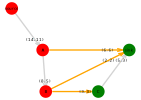

In [34]:
G = SimpleDiGraph(5, 6; seed=18)
node_label = ["A", "B", "source", "C", "sink"]

flow_order = [(8,5), (6,6), (3,3), (2,2), (14,11), (5,3)]

edge_colours = [colorant"lightgray",colorant"orange",colorant"orange",colorant"orange",colorant"lightgray",colorant"lightgray"]
node_colours = [colorant"red", colorant"red", colorant"red", colorant"green", colorant"green"]

gplot(
        G,
        [6.0,6.5,1.0,15.0,20.0],
        [2.0,3.0,1.0,3.0,2.0],
        nodefillc = node_colours,
        nodelabel=node_label, 
        edgelabel=flow_order,
        edgestrokec=edge_colours
    ) 